In [1]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cpu.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=493894 sha256=b24b699f1126df414d2f1451bb6e6daafd2cc3f5f6984d1d1b8f2e81e2439bc6
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1087491 sha256=fe23b8ea60c8e44d528e29f51d5c1964fda7c01ec9e4686694c4e3936172a17d
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38

In [70]:
# import required modules
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from collections import defaultdict

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.metrics import roc_auc_score

# import required modules
import copy
from torch_geometric.nn.conv.gcn_conv import gcn_norm
import torch.nn.functional as F

In [ ]:
movies_path = '/kaggle/input/data-movies/ml-latest-small/movies.csv'
ratings_path = '/kaggle/input/data-movies/ml-latest-small/ratings.csv'

In [4]:
print('movies.csv:')
print(pd.read_csv(movies_path)[["movieId", "genres"]].head())
print('ratings.csv:')
print(pd.read_csv(ratings_path)[["userId", "movieId"]].head())

movies.csv:
   movieId                                       genres
0        1  Adventure|Animation|Children|Comedy|Fantasy
1        2                   Adventure|Children|Fantasy
2        3                               Comedy|Romance
3        4                         Comedy|Drama|Romance
4        5                                       Comedy
ratings.csv:
   userId  movieId
0       1        1
1       1        3
2       1        6
3       1       47
4       1       50


In [5]:
# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

# Use genres as movie input features:34
movie_feat = torch.from_numpy(genres.values).to(torch.float)

         Action  Adventure  Drama  Horror
movieId                                  
1             0          1      0       0
2             0          1      0       0
3             0          0      0       0
4             0          0      1       0
5             0          0      0       0


In [6]:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4

Final edge indices pointing from users to movies:
tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9462, 9463, 9503]])


In [7]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

# Add the node features and edge indices:
data["movie"].x = movie_feat  # TOD
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie # TODO
reverse_edge_index_movie_to_user = edge_index_user_to_movie[[1, 0], :]
data["movie", "rev_rates", "user"].edge_index = reverse_edge_index_movie_to_user
print(data)



HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={ edge_index=[2, 100836] },
  (movie, rev_rates, user)={ edge_index=[2, 100836] }
)


In [8]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val= 0.1,  # 10% of edges for validation
    num_test= 0.1,  # 10% of edges for testing
    disjoint_train_ratio= 0.8,  # 80% of edges for training
    neg_sampling_ratio=2,  # Ratio of negative edges to positive edges
    add_negative_train_samples=1,  # Add negative edges during training
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 16134],
    edge_label=[193608],
    edge_label_index=[2, 193608],
  },
  (movie, rev_rates, user)={ edge_index=[2, 16134] }
)

Validation data:
HeteroData(
  user={ node_id=[610] },
  movie={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, rates, movie)={
    edge_index=[2, 80670],
    edge_label=[30249],
    edge_label_index=[2, 30249],
  },
  (movie, rev_rates, user)={ edge_index=[2, 80670] }
)


In [9]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label

# In the first hop, sample at most 20 neighbors.
# In the second hop, sample at most 10 neighbors.
num_neighbors = [20, 10]

# During training, sample negative edges on-the-fly with a ratio of 2:1.
neg_sampling_ratio = 2

train_loader = LinkNeighborLoader(
    data=train_data,  # Use your training data
    num_neighbors=num_neighbors,
    neg_sampling_ratio=neg_sampling_ratio,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  user={
    node_id=[600],
    n_id=[600],
  },
  movie={
    node_id=[2414],
    x=[2414, 20],
    n_id=[2414],
  },
  (user, rates, movie)={
    edge_index=[2, 8890],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[8890],
    input_id=[128],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 5055],
    e_id=[5055],
  }
)


/opt/conda/lib/python3.10/site-packages/torch_geometric/sampler/neighbor_sampler.py:60: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [10]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        # Define a 2-layer GNN computation graph.
        # Use a *single* `ReLU` non-linearity in-between.
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
            "user": self.user_emb(data["user"].node_id),
            "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )

        return pred

model = Model(hidden_channels=64)

print(model)


Model(
  (movie_lin): Linear(in_features=20, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_emb): Embedding(9742, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(64, 64, aggr=mean)
      (movie__rev_rates__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [11]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
losses = []

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data = sampled_data.to(device)

        # Run `forward` pass of the model
        pred = model(sampled_data)

        # Extract ground truth labels from sampled data
        ground_truth = sampled_data["user", "rates", "movie"].edge_label.float()

        # Apply binary cross entropy loss
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
        losses.append(total_loss / total_examples)
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")


Device: 'cpu'


100%|██████████| 1513/1513 [00:48<00:00, 31.36it/s]


Epoch: 001, Loss: -74927985.5633


100%|██████████| 1513/1513 [00:47<00:00, 31.53it/s]


Epoch: 002, Loss: -11512132960.8103


100%|██████████| 1513/1513 [00:47<00:00, 31.65it/s]


Epoch: 003, Loss: -140899449995.3820


100%|██████████| 1513/1513 [00:48<00:00, 30.93it/s]


Epoch: 004, Loss: -723599182818.2968


100%|██████████| 1513/1513 [00:47<00:00, 31.61it/s]

Epoch: 005, Loss: -2398682633270.6250


Device: 'cpu'


100%|██████████| 1513/1513 [00:48<00:00, 31.13it/s]


Epoch: 001, Loss: -5664866084179.6406


100%|██████████| 1513/1513 [00:49<00:00, 30.83it/s]


Epoch: 002, Loss: -11344451098615.9609


100%|██████████| 1513/1513 [00:47<00:00, 31.58it/s]


Epoch: 003, Loss: -22974631410492.7305


100%|██████████| 1513/1513 [00:48<00:00, 31.31it/s]


Epoch: 004, Loss: -41571758978771.5000


100%|██████████| 1513/1513 [00:47<00:00, 31.60it/s]


Epoch: 005, Loss: -71103206520480.7188


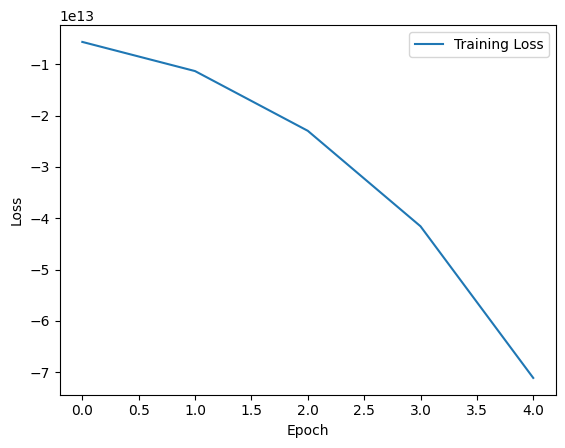

In [12]:
import matplotlib.pyplot as plt
import tqdm
import torch.nn.functional as F
# Lưu giữ loss qua các epoch
losses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data = sampled_data.to(device)

        # Run `forward` pass of the model
        pred = model(sampled_data)

        # Extract ground truth labels from sampled data
        ground_truth = sampled_data["user", "rates", "movie"].edge_label.float()

        # Apply binary cross entropy loss
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    # Lưu giữ giá trị loss cho việc vẽ đồ thị sau này
    losses.append(total_loss / total_examples)

    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

# Vẽ đồ thị loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  user={
    node_id=[605],
    n_id=[605],
  },
  movie={
    node_id=[2669],
    x=[2669, 20],
    n_id=[2669],
  },
  (user, rates, movie)={
    edge_index=[2, 18992],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[18992],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7684],
    e_id=[7684],
  }
)


In [14]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        # Collect predictions and ground-truths
        pred = model(sampled_data)
        preds.append(pred)
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 79/79 [00:03<00:00, 22.15it/s]

Validation AUC: 0.7005


In [15]:
for i, sampled_data in enumerate(val_loader):
    if i == 0:
        # In ra thông tin của mẫu đầu tiên
        print(sampled_data)
        break

HeteroData(
  user={
    node_id=[607],
    n_id=[607],
  },
  movie={
    node_id=[2665],
    x=[2665, 20],
    n_id=[2665],
  },
  (user, rates, movie)={
    edge_index=[2, 18764],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[18764],
    input_id=[384],
  },
  (movie, rev_rates, user)={
    edge_index=[2, 7794],
    e_id=[7794],
  }
)


In [16]:
import torch.nn.functional as F

probabilities = F.sigmoid(torch.Tensor(pred))

print(probabilities)


tensor([1., 1., 1.,  ..., 1., 1., 1.])


In [17]:
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data = sampled_data.to(device)

        # Run `forward` pass of the model
        pred = model(sampled_data)

        # Extract ground truth labels from sampled data
        ground_truth = sampled_data["user", "rates", "movie"].edge_label.float()

        # Apply binary cross entropy loss
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")


Device: 'cpu'


100%|██████████| 1513/1513 [00:48<00:00, 31.48it/s]


Epoch: 001, Loss: -112554791213245.9844


100%|██████████| 1513/1513 [00:47<00:00, 31.73it/s]


Epoch: 002, Loss: -168081859057516.1562


100%|██████████| 1513/1513 [00:49<00:00, 30.79it/s]


Epoch: 003, Loss: -255381471304639.0625


100%|██████████| 1513/1513 [00:48<00:00, 31.46it/s]


Epoch: 004, Loss: -371851774775793.4375


100%|██████████| 1513/1513 [00:48<00:00, 30.93it/s]

Epoch: 005, Loss: -530288337689475.5000


### LightGCN

In [47]:
rating_path = '/kaggle/input/data-movies/ml-latest-small/ratings.csv'

In [48]:
rating_df = pd.read_csv(rating_path)

In [49]:
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [50]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [51]:
# load edges between users and movies
def load_edge_csv(df, 
                  src_index_col, 
                  dst_index_col,  
                  link_index_col, 
                  rating_threshold=3.5):
    """Loads csv containing edges between users and items

    Args:
        path (str): path to csv file
        src_index_col (str): column name of users
        src_mapping (dict): mapping between row number and user id
        dst_index_col (str): column name of items
        dst_mapping (dict): mapping between row number and item id
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
    """
    
    edge_index = None
    src = [user_id for user_id in  df['userId']]
    
    num_users = len(df['userId'].unique())

    dst = [(movie_id) for movie_id in df['movieId']]
    
    link_vals = df[link_index_col].values

    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold

    edge_values = []

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            edge_values.append(link_vals[i])

    # edge_values is the label we will use for compute training loss                
    return edge_index, edge_values

In [52]:
edge_index, edge_values = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=1 # need to use threshold=1 so the model can learn based on RMSE
)

In [53]:
edge_index = torch.LongTensor(edge_index) 
edge_values = torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])
tensor([4., 4., 4.,  ..., 5., 5., 3.], dtype=torch.float64)
torch.Size([99466])


In [54]:
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

print(f"num_users {num_users}, num_movies {num_movies}")

num_users 610, num_movies 9724


In [55]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i] # assign actual edge value to Interaction Matrix

    R_transpose = torch.transpose(R, 0, 1)
    
    # create adj_matrix
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [56]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
    
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           value = input_edge_values,
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))
    
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()
    
    return r_mat_edge_index, r_mat_edge_values

In [57]:
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2, 
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5, 
                                             random_state=1)

In [58]:
train_edge_index = edge_index[:, train_indices]
train_edge_value = edge_values[train_indices]

val_edge_index = edge_index[:, val_indices]
val_edge_value = edge_values[val_indices]

test_edge_index = edge_index[:, test_indices]
test_edge_value = edge_values[test_indices]

In [59]:
edge_index[:, test_indices]

tensor([[ 183,  181,   20,  ...,  433,  381,   84],
        [9636,  486,  584,  ...,   31,  224, 1222]])

In [60]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

print(test_edge_value)
print(test_edge_value.size())

num_users 610, num_movies 9724, num_interactions 99466
train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([8898])
tensor([4.5000, 3.5000, 3.5000,  ..., 3.5000, 5.0000, 1.0000],
       dtype=torch.float64)
torch.Size([9947])


In [61]:
train_edge_index, train_edge_values  = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_value)

In [62]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n {train_edge_values} \n {train_edge_values.size()}")
print(f"\n val_edge_values: \n {val_edge_values} \n {val_edge_values.size()}")
print(f"\n test_edge_values: \n {test_edge_values} \n {test_edge_values.size()}")

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])

 train_edge_values: 
 tensor([4.0000, 4.0000, 5.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([159144])

 val_edge_values: 
 tensor([4.0000, 5.0000, 4.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([19894])

 test_edge_values: 
 tensor([5.0000, 5.0000, 5.0000,  ..., 3.0000, 4.5000, 2.5000]) 
 torch.Size([19894])


In [63]:
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.dropout_rate = dropout_rate
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops


        # define user and item embedding for direct look up. 
        # embedding dimension: num_user/num_item x embedding_dim
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        
        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
        # create a linear layer (fully connected layer) so we can output a single value (predicted_rating)
        self.out = nn.Linear(embedding_dim + embedding_dim, 1)

    def forward(self, edge_index: Tensor, edge_values: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        
        """
            compute \tilde{A}: symmetrically normalized adjacency matrix
            \tilde_A = D^(-1/2) * A * D^(-1/2)    according to LightGCN paper
        
            this is essentially a metrix operation way to get 1/ (sqrt(n_neighbors_i) * sqrt(n_neighbors_j))

        
            if your original edge_index look like
            tensor([[   0,    0,    0,  ...,  609,  609,  609],
                    [   0,    2,    5,  ..., 9444, 9445, 9485]])
                    
                    torch.Size([2, 99466])
                    
            then this will output: 
                (
                 tensor([[   0,    0,    0,  ...,  609,  609,  609],
                         [   0,    2,    5,  ..., 9444, 9445, 9485]]), 
                 tensor([0.0047, 0.0096, 0.0068,  ..., 0.0592, 0.0459, 0.1325])
                 )
                 
              where edge_index_norm[0] is just the original edge_index
              
              and edge_index_norm[1] is the symmetrically normalization term. 
              
            under the hood it's basically doing
                def compute_gcn_norm(edge_index, emb):
                    emb = emb.weight
                    from_, to_ = edge_index
                    deg = degree(to_, emb.size(0), dtype=emb.dtype)
                    deg_inv_sqrt = deg.pow(-0.5)
                    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
                    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

                    return norm
                 
                
        """
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list
        
        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0 

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
            
            
        # this is doing the formula8 in LightGCN paper  
            
        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len. 
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)
        
        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K
        
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                       [self.num_users, self.num_items]) # splits into e_u^K and e_i^K


        r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)
        
        src, dest =  r_mat_edge_index[0], r_mat_edge_index[1]
        
        # applying embedding lookup to get embeddings for src nodes and dest nodes in the edge list
        user_embeds = users_emb_final[src]
        item_embeds = items_emb_final[dest]
        
        # output dim: edge_index_len x 128 (given 64 is the original emb_vector_len)
        output = torch.cat([user_embeds, item_embeds], dim=1)
        
        # push it through the linear layer
        output = self.out(output)
        
        return output
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

layers = 1 
model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

In [64]:
ITERATIONS = 1000
EPOCHS = 10

BATCH_SIZE = 1024

LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 10
LAMBDA = 1e-6

In [65]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [66]:
model = model.to(device)
model.train()

# add decay to avoid overfit
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)


loss_func = nn.MSELoss()

In [67]:
def get_recall_at_k(input_edge_index, 
                     input_edge_values, # the true label of actual ratings for each user/item interaction
                     pred_ratings, # the list of predicted ratings
                     k=10, 
                     threshold=3.5):
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)

        for i in range(len(input_edge_index[0])):
            src = input_edge_index[0][i].item()
            dest = input_edge_index[1][i].item()
            true_rating = input_edge_values[i].item()
            pred_rating = pred_ratings[i].item()

            user_item_rating_list[src].append((pred_rating, true_rating))

        recalls = dict()
        precisions = dict()

        for user_id, user_ratings in user_item_rating_list.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
            
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
            recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        overall_recall = sum(rec for rec in recalls.values()) / len(recalls)
        overall_precision = sum(prec for prec in precisions.values()) / len(precisions)

        return overall_recall, overall_precision
    

In [68]:
r_mat_train_edge_index, r_mat_train_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index, train_edge_values)
r_mat_val_edge_index, r_mat_val_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index, val_edge_values)
r_mat_test_edge_index, r_mat_test_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index, test_edge_values)

In [71]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation

    # the rating here is based on r_mat
    pred_ratings = model.forward(train_edge_index, train_edge_values)
    

    train_loss = loss_func(pred_ratings, r_mat_train_edge_values.view(-1,1))    

        
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # going over validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()

        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index, val_edge_values)
            
            val_loss = loss_func(val_pred_ratings, r_mat_val_edge_values.view(-1,1)).sum()
            
            recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_edge_index, 
                                                          r_mat_val_edge_values, 
                                                          val_pred_ratings, 
                                                          k = 20
                                                         )
    
                
            val_recall_at_ks.append(round(recall_at_k, 5))
            train_losses.append(train_loss.item())
            val_losses.append(val_loss.item())
        
            print(f"[Iteration {iter}/{ITERATIONS}], train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss.item(), 5)},  recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

[Iteration 0/1000], train_loss: 13.37709, val_loss: 13.3525,  recall_at_k 0.0, precision_at_k 0.0
[Iteration 200/1000], train_loss: 2.36672, val_loss: 2.48143,  recall_at_k 0.01129, precision_at_k 0.11341
[Iteration 400/1000], train_loss: 1.53367, val_loss: 1.60614,  recall_at_k 0.07225, precision_at_k 0.29459
[Iteration 600/1000], train_loss: 1.29703, val_loss: 1.36158,  recall_at_k 0.11422, precision_at_k 0.36754
[Iteration 800/1000], train_loss: 1.17545, val_loss: 1.23621,  recall_at_k 0.14359, precision_at_k 0.4134


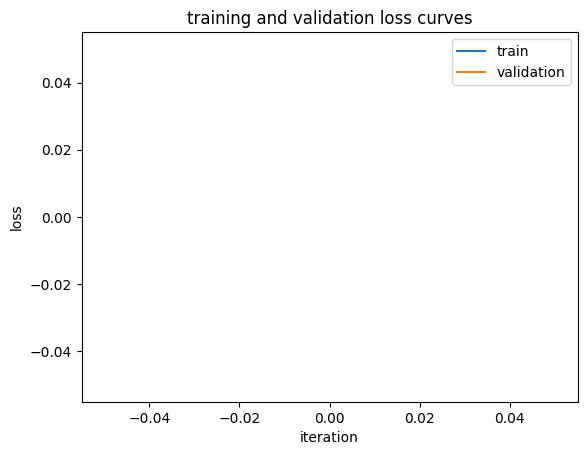

In [42]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    pred_ratings = model.forward(test_edge_index, test_edge_values)
    recall_at_k, precision_at_k = get_recall_at_k(r_mat_test_edge_index, 
                                                  r_mat_test_edge_values, 
                                                  pred_ratings, 20)
    print(f"recall_at_k {round(recall_at_k, 5)}, precision_at_k {round(precision_at_k, 5)}")

In [ ]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()